In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import time

In [2]:
from simulation_tools import Servo, PRBS, simulation_init

In [14]:
def relu(z):
    return z * (z > 0)
    
def generate_gains(w, e, y_0):
    network_input = np.array([e, y_0])
    z1 = np.matmul(network_input, w[0])  
    a1 = relu(z1)
    z2 = np.matmul(a1, w[1])
    gains = relu(z2)
    return gains

def run_episode(servo, T, y0, r, d, w, error_term):
    servo.PID.reset()
    dy = np.zeros(len(T))
    y = np.zeros(len(T))
    angle = np.zeros(len(T))

    dy[0] = y0[0]
    y[0] = y0[1]

    angle[0] = y[0] * 180/math.pi + 180
    err = 0
    
    for i in range(1, len(T)):

        e = r[i] - angle[i-1]
        
        d_t = T[i] - T[i-1]
        if error_term == 'ITSE':
            err += T[i] * (e**2) * d_t
        elif error_term == 'ISE':
            err += (e**2) * d_t
        Kp, Ki, Kd = generate_gains(w, e, y[i-1])
        servo.PID.update_gains(Kp, Ki, Kd)
        state, angle[i] = servo.simulate_step([dy[i-1], y[i-1]], angle[i-1], [T[i-1], T[i]], r[i], d[i])
        dy[i] = state[0]
        y[i] = state[1]

        
    return err, angle

In [15]:
def init_population(pop_size, w1_shape, w2_shape):
    init_weights = []
    for p in range(pop_size):
        w1 = np.random.uniform(low=-0.1, high=0.1, size=w1_shape)
        w2 = np.random.uniform(low=-0.1, high=0.1, size=w2_shape)
        init_weights.append([w1, w2])
                            
    return init_weights

def flatten_weights(weights):
    flattened = []
    for w in weights:
        flattened.append([w[0].flatten(),w[1].flatten()])
    return flattened

def unflatten_weights(weights, w1_shape, w2_shape):
    unflattened = []
    for w in weights:
        unflattened.append([w[0].reshape(w1_shape),w[1].reshape(w2_shape)])
    return unflattened

def random_weight_select(parent_1, parent_2, weight_num):
    offspring = np.zeros(len(parent_1[weight_num]))
    for i in range(len(parent_1[weight_num])):
        rand_int = np.random.randint(0, 2)
        if rand_int == 0:
            offspring[i] = parent_1[weight_num][i]
        else:
            offspring[i] = parent_2[weight_num][i]
    return offspring

def breed_weights(parents_flat, offspring_size):
    offspring_flat = []

    for k in range(offspring_size):
        parent_1_idx = k%len(parents_flat)
        parent_2_idx = (k+1)%len(parents_flat)

        offspring_flat.append([random_weight_select(parents_flat[parent_1_idx], parents_flat[parent_2_idx], 0), 
                          random_weight_select(parents_flat[parent_1_idx], parents_flat[parent_2_idx], 1)])

    return offspring_flat

def mutate_weight(weight, mutation):
    num_to_mutate = np.uint8(np.ceil(len(weight)*mutation))
    random_idx = np.arange(len(weight))
    np.random.shuffle(random_idx)
    for i in range(num_to_mutate):
        weight[random_idx[i]] += np.random.uniform(-1.0, 1.0, 1)
    return weight

def mutate(offspring_flat, mutation):
    offspring_flat_mutated = []
    for osf in offspring_flat:
        offspring_flat_mutated.append([mutate_weight(osf[0], mutation),
                                       mutate_weight(osf[1], mutation)])
    return offspring_flat_mutated

In [20]:
def run_genetic_nn(pop_size, num_parents_mating, num_generations, mutation_val, error_term, 
                   step_mutation=False, step_mutation_end=0.1):
    
    T, r, d, d_test, y0 = simulation_init(0.005, 5, 2)
    
    #Generate mutation steps
    if step_mutation:
        mutation = np.linspace(mutation_val, step_mutation_end, num=num_generations)
    else:
        mutation = np.ones(num_generations) * mutation_val
        
    w1_shape = (2, 4)
    w2_shape = (4, 3)
    
    servo = Servo("rotation", 0.32, 0.06, 0.00879)
    
    #Create randomly initialized weights
    pop_weights = init_population(pop_size, w1_shape, w2_shape)

    for n in range(num_generations):
        err_population = []
        y_p_population = np.ndarray(shape=(pop_size, len(T)))

        #For each weights in the population calculate err and get plant output
        for p in range(pop_size):
            err_population.append([0, 0])
            err_population[p][0] = p
            err_population[p][1], y_p_population[p] = run_episode(servo, T, y0, r, d, pop_weights[p], error_term)

        if (n+1) % (num_generations//10) == 0 or n == 0:
            #Ploting plant output
            for y_p in y_p_population:
                plt.plot(T, y_p)

            plt.plot(T, r, '--')
            plt.plot(T, d + 180, '--')
            plt.title("Generation " + str(n+1))
            plt.legend(['Setpoint', 'Disturbance'])
            plt.show()

        #Get top weights
        err_population.sort(key=lambda x: x[1])
        top_weights = []
        for k in range(num_parents_mating):
            top_weights.append(pop_weights[err_population[k][0]])
        best_weights = top_weights[0]

        #Flatten top weights so we can breed them easier
        top_weights_flattened = flatten_weights(top_weights)
        #Create offspring
        offspring_flat = breed_weights(top_weights_flattened, pop_size - num_parents_mating)
        #Mutate offspring
        offspring_flat_mutated = mutate(offspring_flat, mutation[n])
        #Unflatten offspring
        offspring_mutated = unflatten_weights(offspring_flat_mutated, w1_shape, w2_shape)

        #Add mutated offspring to the top weights to create the new population
        pop_weights = top_weights + offspring_mutated
        
    #Always use ITSE to compare errors
    ITSE, y_p = run_episode(servo, T, y0, r, d_test, best_weights, 'ITSE')
    plt.plot(T, y_p)
    plt.plot(T, r, '--')
    plt.plot(T, d_test + 180, '--')
    plt.title("Best parameters")
    plt.show()

    print("Best parameter ITSE:", ITSE)
    
    return best_weights

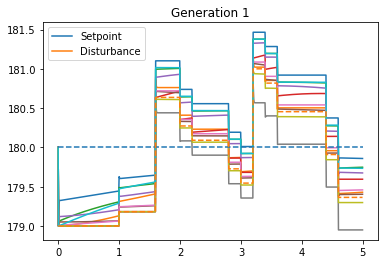

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


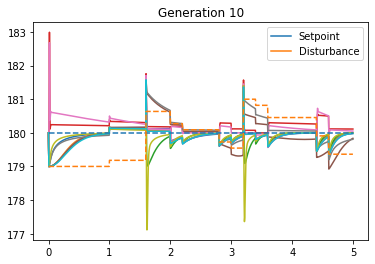

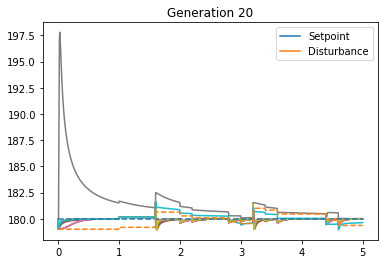

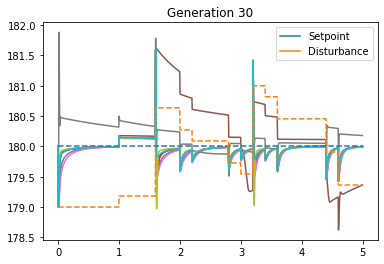

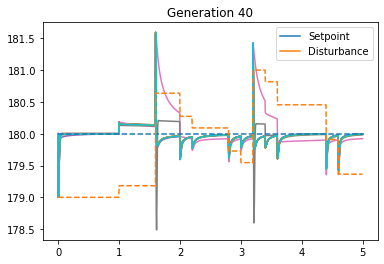

c:\users\james\envs\slw_env\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


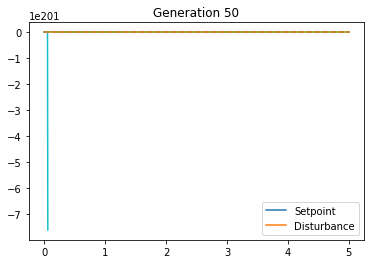

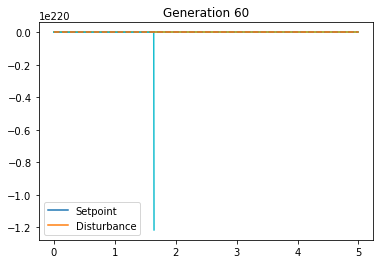

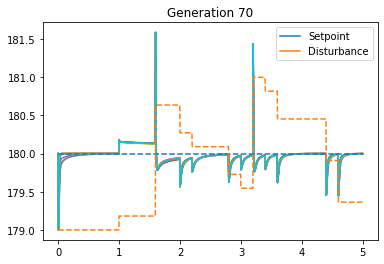

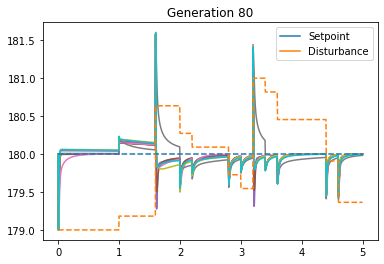

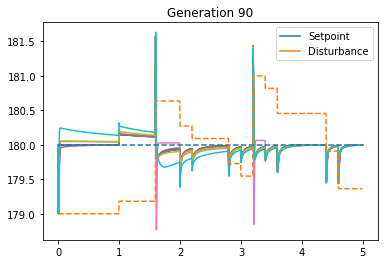

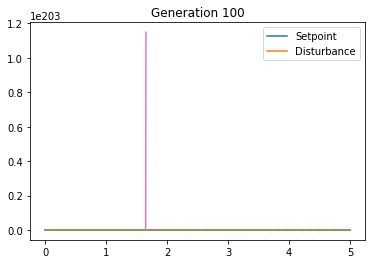

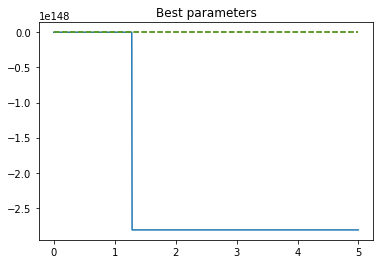

Best parameter ITSE: 9.22639482207323e+297


[array([[-0.02088115,  0.70031435, -0.04306819,  1.12429162],
        [ 0.36286669, -2.23693411, -2.23515086,  2.07471588]]),
 array([[ 1.19500879, -0.23947488, -0.62764344],
        [ 0.46586707,  5.05124709, -0.34774999],
        [ 3.46554066, -1.91569397,  1.19043178],
        [ 2.52746614,  0.81223073,  0.23012376]])]

In [21]:
run_genetic_nn(pop_size=10, num_parents_mating=4, num_generations=100,
                     mutation_val=0.1, error_term='ITSE')

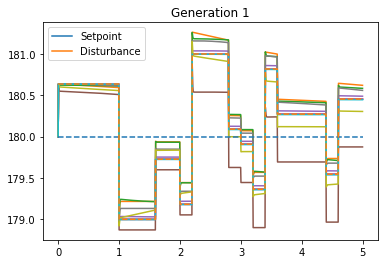

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


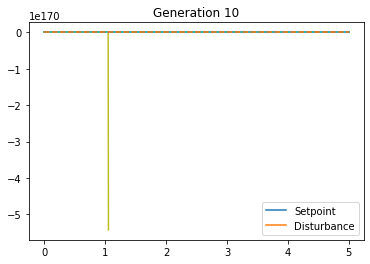

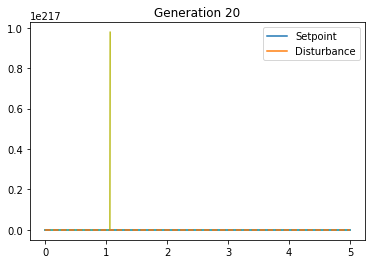

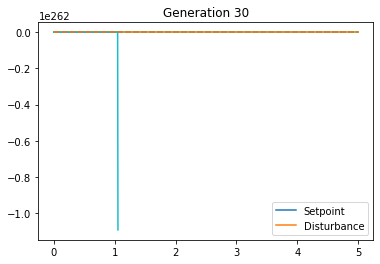

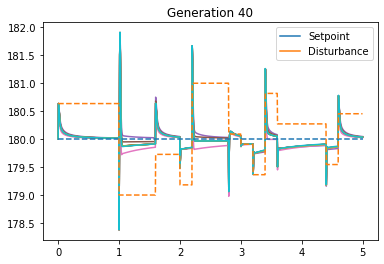

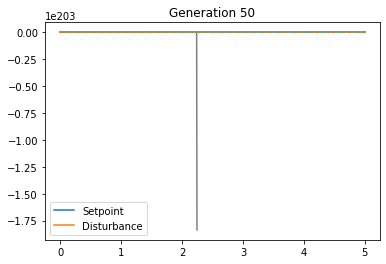

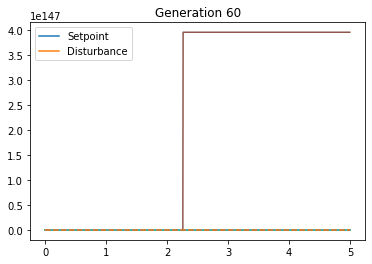

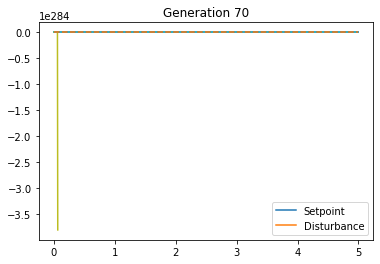

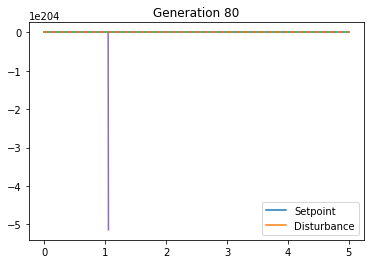

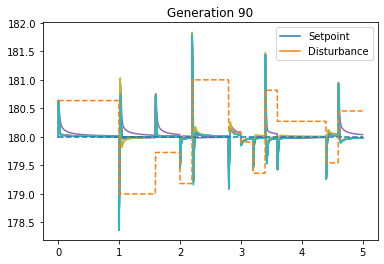

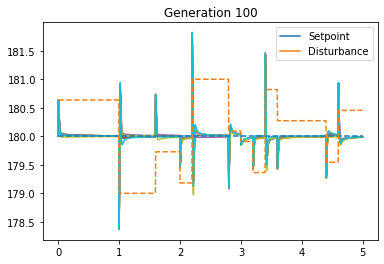

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars


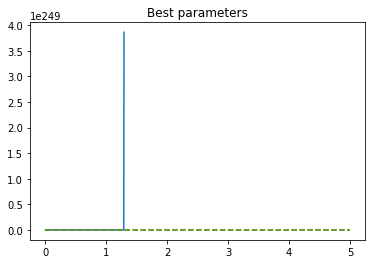

Best parameter ITSE: nan


[array([[ 1.64157167,  0.34995401, -1.10158824, -0.59079605],
        [ 0.06688393,  2.39141445, -1.43154128,  0.15016042]]),
 array([[ 3.10379468,  0.23981098, -0.68805635],
        [ 1.14899047, -1.63221216,  1.11659171],
        [ 2.84277951, -1.43963257, -0.88005137],
        [ 2.57091864,  1.41790887, -1.56057722]])]

In [23]:
run_genetic_nn(pop_size=10, num_parents_mating=4, num_generations=100, 
                     mutation_val=0.1, error_term='ISE')

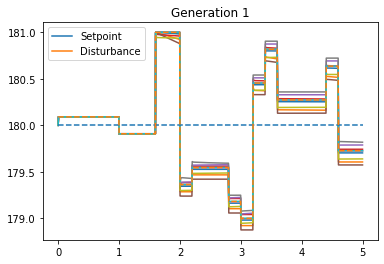

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


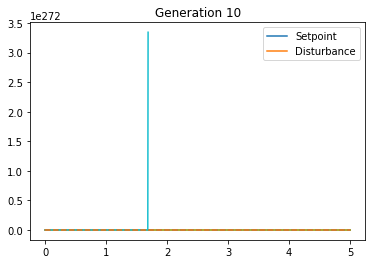

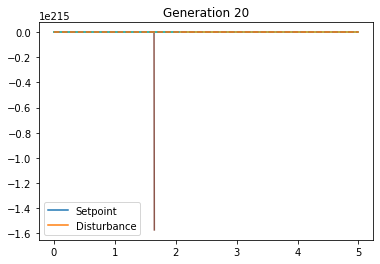

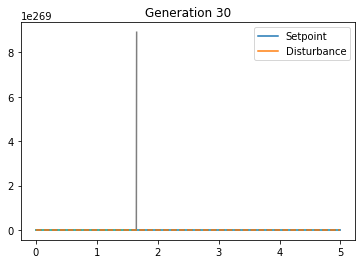

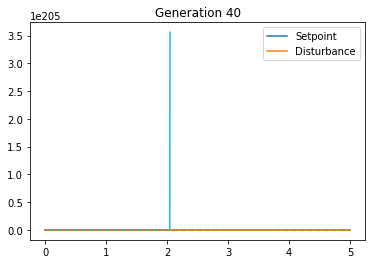

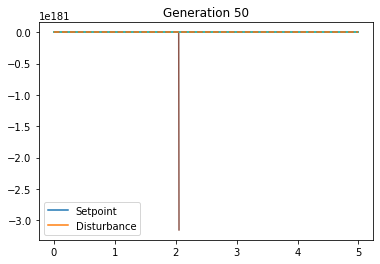

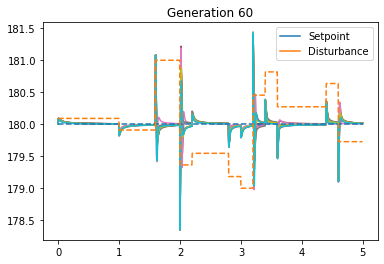

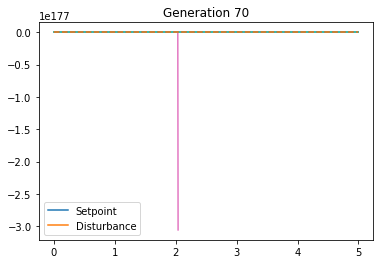

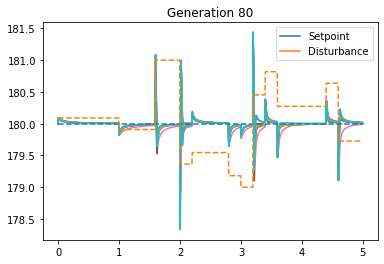

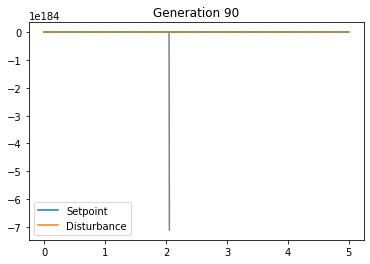

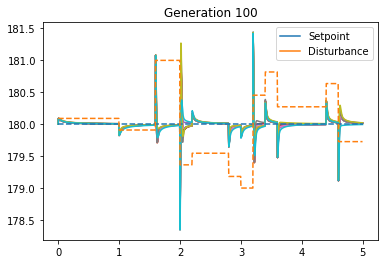

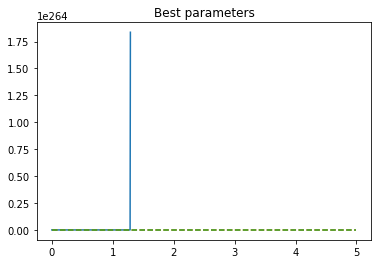

Best parameter ITSE: nan


[array([[ 1.97410054, -2.14247253,  1.45286161,  1.31278354],
        [ 1.18821423, -1.10887932,  1.81551246,  2.57042059]]),
 array([[-0.59219155, -0.73902518,  0.95195622],
        [ 2.62143344, -2.44334845, -3.26990082],
        [ 1.96330634,  3.86209372, -0.8575118 ],
        [ 2.83661166,  0.10077361, -2.22671495]])]

In [24]:
run_genetic_nn(pop_size=10, num_parents_mating=4, num_generations=100, 
                     mutation_val=0.5, error_term='ITSE')

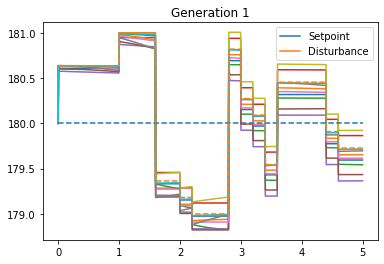

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


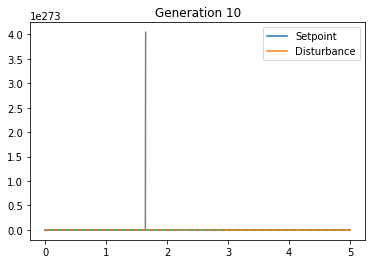

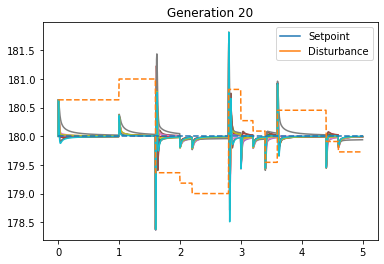

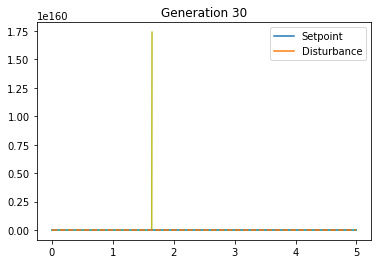

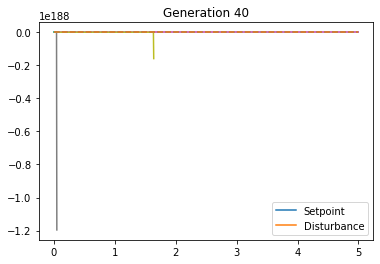

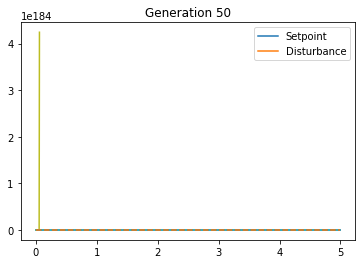

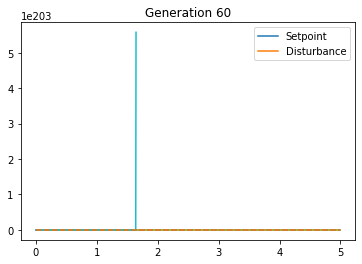

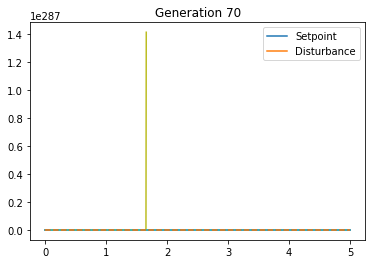

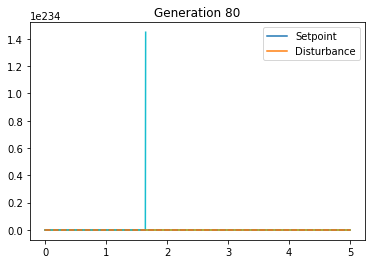

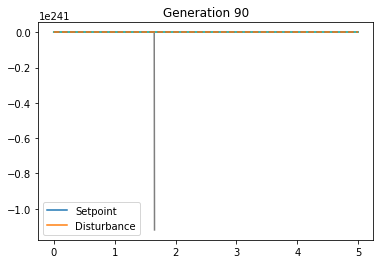

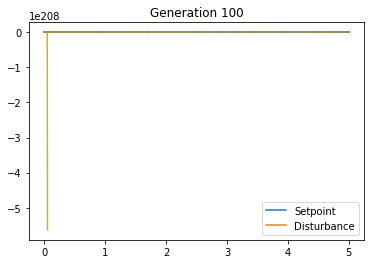

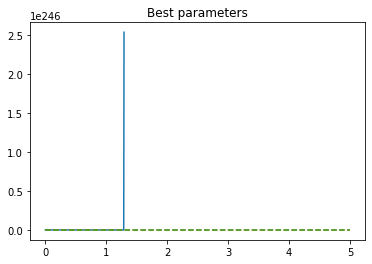

Best parameter ITSE: nan


[array([[-1.38280898, -2.30304206,  2.94715161, -1.26888066],
        [-2.59435217, -1.4825117 ,  1.14304922,  0.66615153]]),
 array([[ 2.27139479,  0.69484128,  0.29105106],
        [ 1.29570187,  1.25436601,  0.9855552 ],
        [ 1.9534225 ,  1.38936254, -0.10946961],
        [-1.39942247,  1.80795681, -2.73000668]])]

In [25]:
run_genetic_nn(pop_size=10, num_parents_mating=4, num_generations=100, 
                     mutation_val=0.5, error_term='ITSE', step_mutation=True, step_mutation_end=0.1)

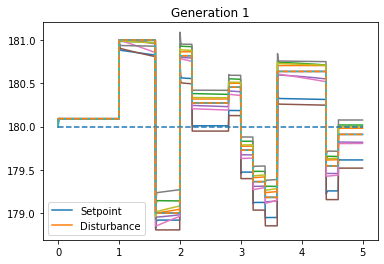

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


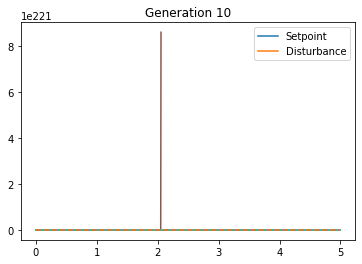

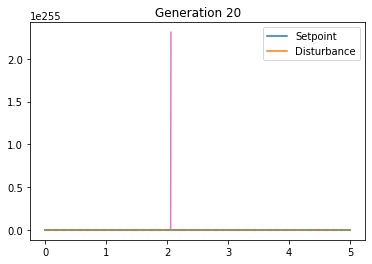

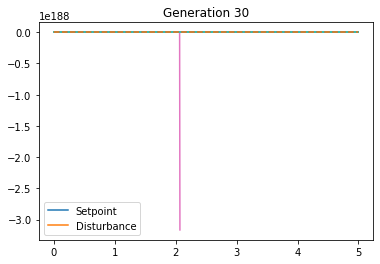

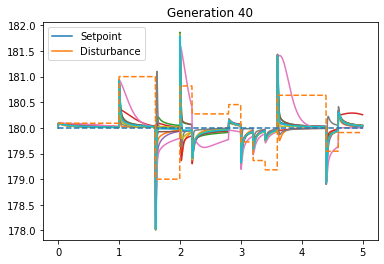

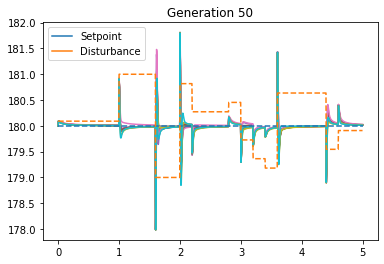

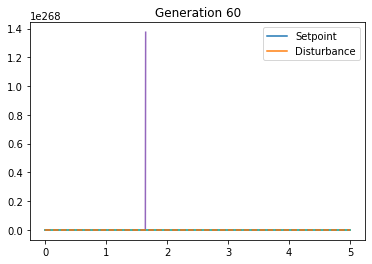

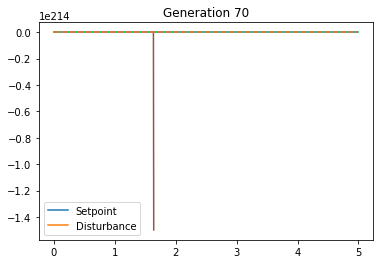

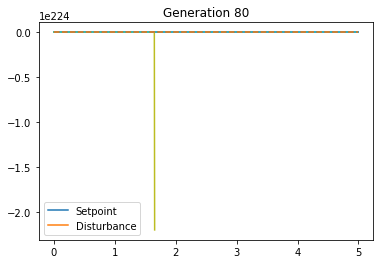

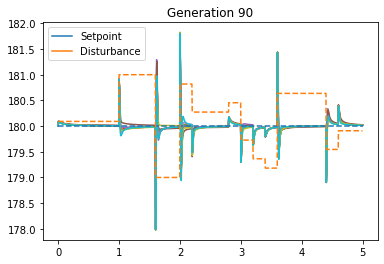

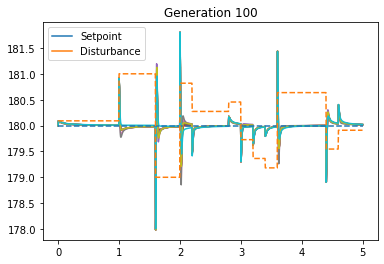

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars


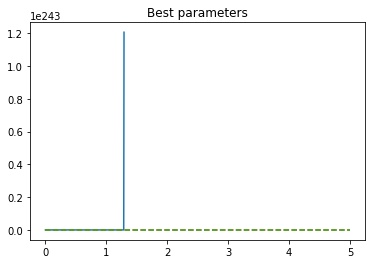

Best parameter ITSE: nan


[array([[-0.94080135,  2.24877195,  2.49141601, -2.04996049],
        [ 0.488665  , -0.70133376, -0.49444639,  0.34855728]]),
 array([[-0.59857287,  0.05835062, -0.11553788],
        [ 1.21428112,  1.15649912,  0.44557988],
        [ 0.74902066,  0.19507908, -0.98432174],
        [ 2.5475023 , -0.2551661 , -2.10241651]])]

In [26]:
run_genetic_nn(pop_size=10, num_parents_mating=4, num_generations=100, 
                     mutation_val=0.5, error_term='ISE', step_mutation=True, step_mutation_end=0.1)

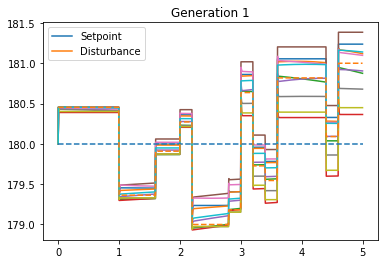

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


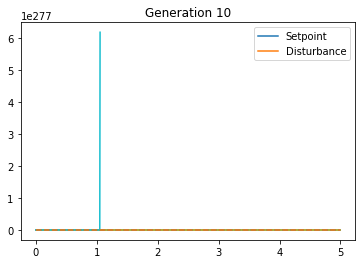

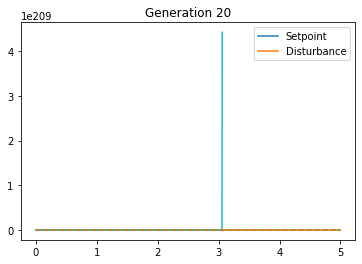

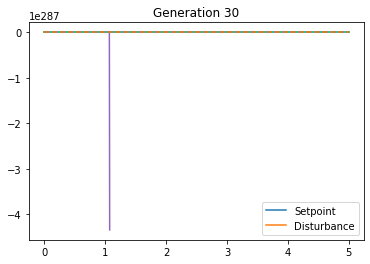

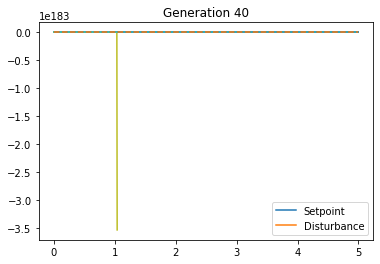

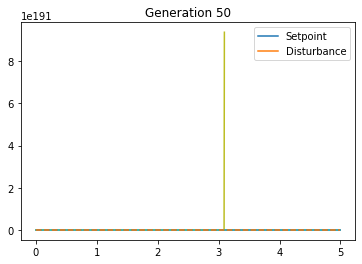

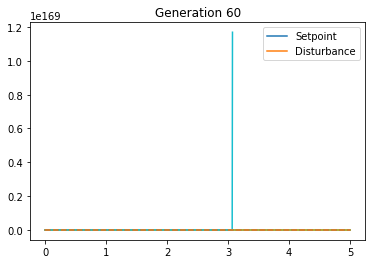

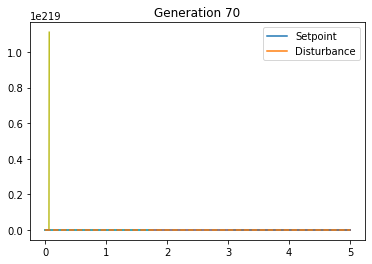

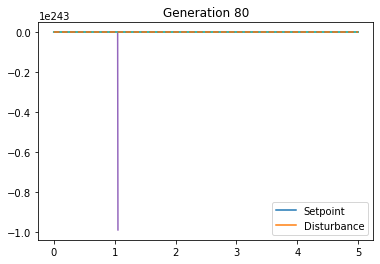

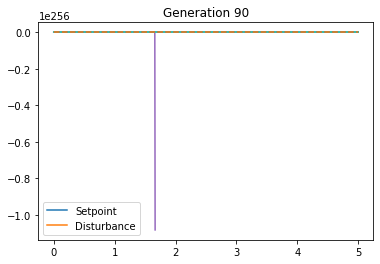

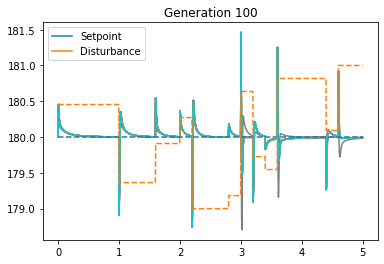

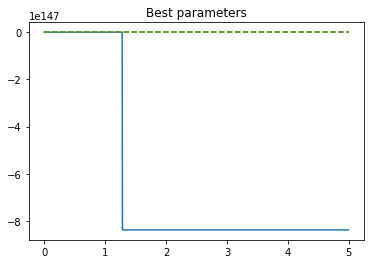

Best parameter ITSE: 8.185638865358735e+296


[array([[ 1.00777733, -0.98571701, -0.05683585,  1.98630315],
        [-0.29931125,  1.9584882 , -2.12707075,  1.06850046]]),
 array([[ 2.26994407,  1.04962615,  0.52695144],
        [ 2.60556217,  4.30040159,  0.06503382],
        [ 1.0059078 , -1.24872328, -0.682114  ],
        [ 2.05535176, -0.72614471, -1.40036536]])]

In [27]:
run_genetic_nn(pop_size=10, num_parents_mating=4, num_generations=100, 
                     mutation_val=0.5, error_term='ITSE', step_mutation=True, step_mutation_end=0.1)

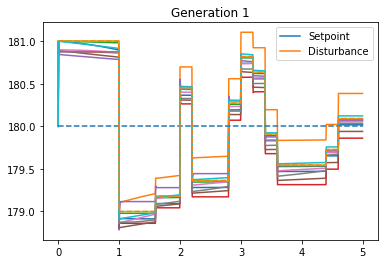

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


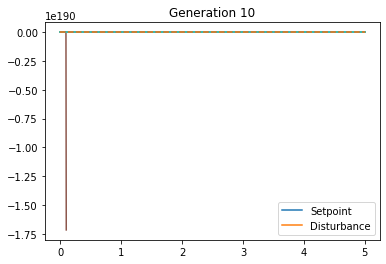

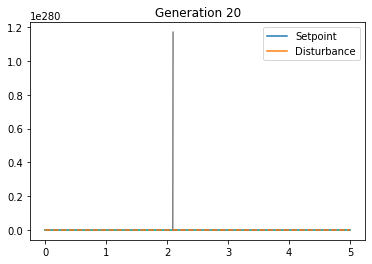

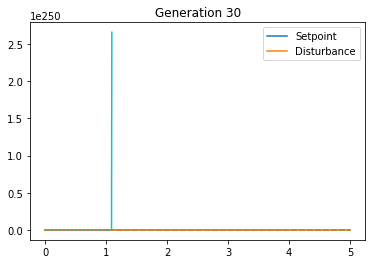

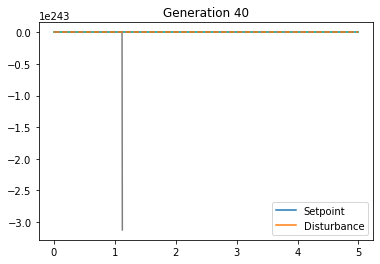

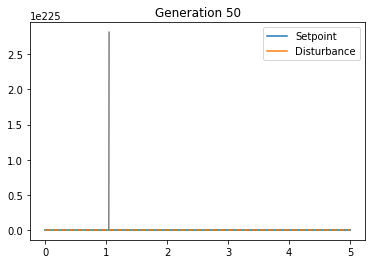

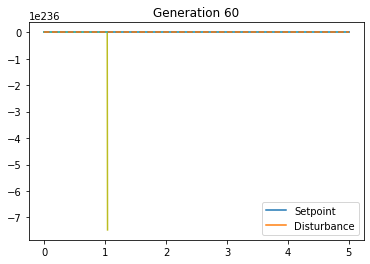

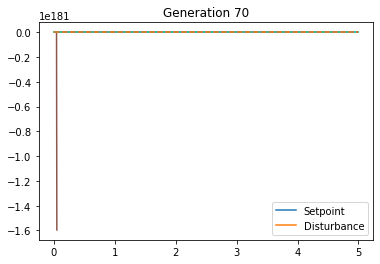

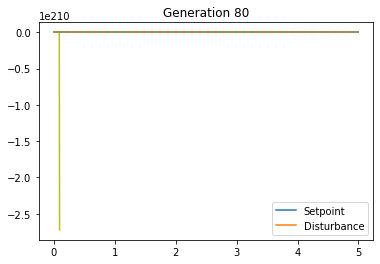

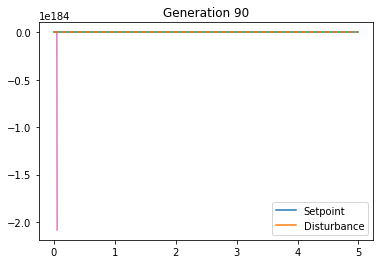

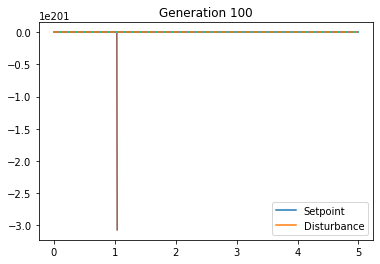

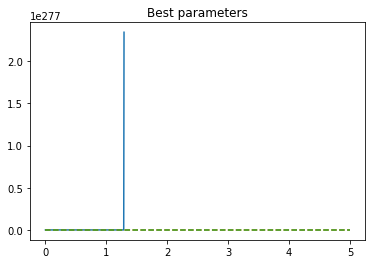

Best parameter ITSE: nan


[array([[-2.52887173,  2.97407551,  1.96952045, -0.26345846],
        [ 0.61283467,  1.59937273, -2.13164506, -2.06298887]]),
 array([[ 2.75016745, -1.87168295, -0.69522031],
        [ 1.61073545,  5.43345801, -0.17302902],
        [-0.23032386,  0.66089151, -1.3729565 ],
        [ 1.3836455 ,  1.81297645, -0.04778212]])]

In [28]:
run_genetic_nn(pop_size=10, num_parents_mating=4, num_generations=100, 
                     mutation_val=0.8, error_term='ITSE')

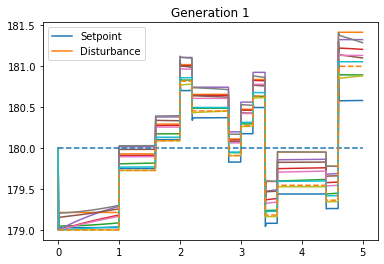

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


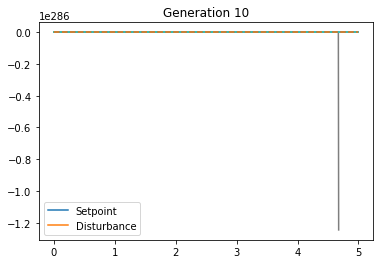

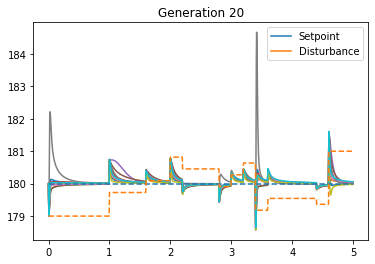

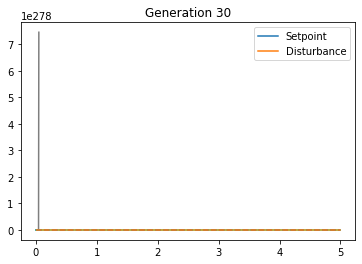

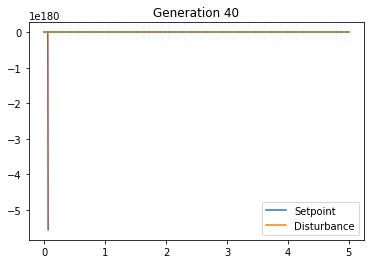

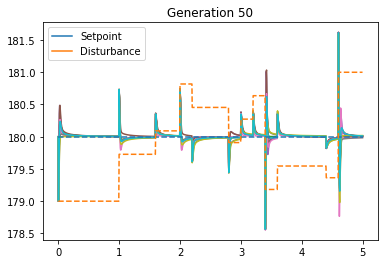

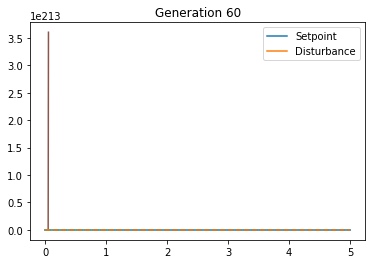

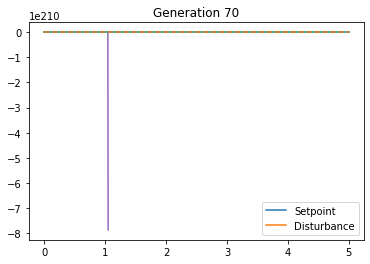

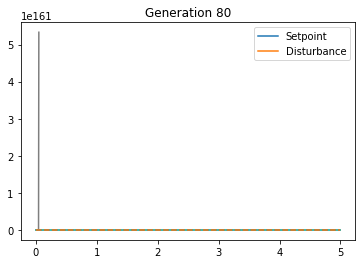

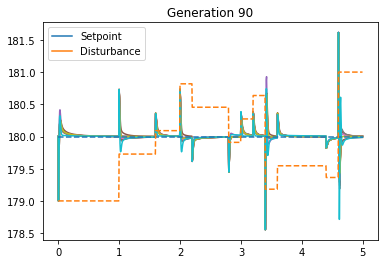

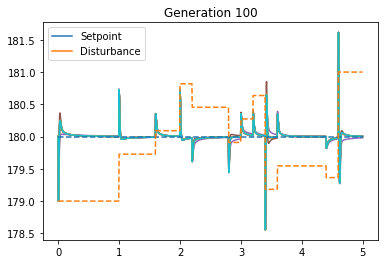

c:\users\james\envs\slw_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars


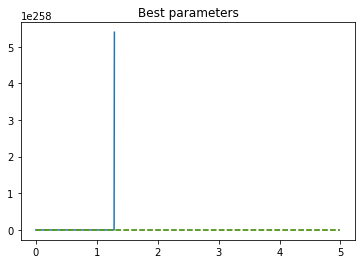

Best parameter ITSE: nan


[array([[ 2.6642185 , -1.5900802 , -2.807425  , -0.40723835],
        [-2.02981987, -0.71392723,  1.22178018, -0.00693875]]),
 array([[ 2.20223098, -2.03576313, -0.25453027],
        [-1.19113384,  1.55707016, -0.294289  ],
        [ 2.51068116,  2.14612042, -0.17612895],
        [-0.33958599,  1.66849548, -3.04138978]])]

In [29]:
run_genetic_nn(pop_size=10, num_parents_mating=4, num_generations=100, 
                     mutation_val=0.5, error_term='ISE', step_mutation=True, step_mutation_end=0.1)